# Example:  Optimal Estimation for Atmospheric Correction (Inverse)

Part of ESE 156 Remote Sensing Class<br>
Taught by Prof. Christian Frankenberg<br>
Guest Lecture by David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

Import dependencies.  You'll want to replace the filepaths below with your own installation of ISOFIT.

In [18]:
import sys
import scipy as s
sys.path.insert(0,'/Users/drt/src/isofit-ese156/isofit')
import isofit
from RSE_style import *

from forward import ForwardModel
from geometry import Geometry
from inverse import Inversion
from common import spectrumResample

Define all model components.  Our remote observation is the spatial average of a rectangular region comprising 294 spectra, so we include this information in our instrument configuration.

In [67]:

instrument_config = {"wavelength_file": "../data/wavelengths.txt",
                     "integrations": 294,
                     "noise_file": "../data/avirisng_noise.txt",
                     "unknowns": {"cal_uncertainty_systematic_file": "../data/avirisng_systematic_error.txt",
                                  "cal_uncertainty_flatfield": 0.0}}

rtm_config = {"lut_path":"../data/lut/",
              "modtran_template_file":"../data/modtran.json",
              "domain": {"start": 350, "end": 2520, "step": 0.1},
              "statevector": {
                 "H2OSTR": {"bounds": [1.5, 2.0], "scale": 0.01, "init": 1.75},
                 "AOT550": {"bounds": [0.01, 0.1], "scale": 0.01, "init": 0.05}},
              "lut_grid": {"H2OSTR": [1.5, 2.0], "AOT550": [0.01, 0.1]},
              "unknowns": {"H2O_ABSCO": 0.01},
              "auto_rebuild":False}

surface_config = {"surface_file": "../data/surface.mat"}
geom = Geometry()

fm = ForwardModel({"instrument":instrument_config,
                   "multicomponent_surface":surface_config,
                   "modtran_radiative_transfer": rtm_config})


We will define a new object - an "Inversion" that finds a Maximum A Posteriori solution for the state vector, given our radiance and priors. 

In [68]:
from inverse import Inversion

inverse_config = {"windows":[[380.0,1300.0],[1450,1780.0],[1950.0,2450.0]]}
iv = Inversion(inverse_config, fm)

Load our Beckman Lawn reflectance, and try the inversion.

In [69]:
wavelengths, radiance = s.loadtxt('../data/beckmanlawn_radiance.txt').T
state_est = iv.invert(radiance, geom)

Iteration: 1  Time: 0.104060  Residual: 28848.696051  Mean DOF: 0.569 
 Component: 7 Atmosphere: 1.896 0.050
Iteration: 2  Time: 0.300433  Residual: 20288.213097  Mean DOF: 0.568 
 Component: 7 Atmosphere: 1.952 0.036
Iteration: 3  Time: 0.189687  Residual: 7944.032549  Mean DOF: 0.569 
 Component: 7 Atmosphere: 2.000 0.035
Iteration: 4  Time: 0.179129  Residual: 3041.425454  Mean DOF: 0.570 
 Component: 7 Atmosphere: 2.000 0.035
Iteration: 5  Time: 0.182651  Residual: 1003.001778  Mean DOF: 0.571 
 Component: 7 Atmosphere: 2.000 0.034
Iteration: 6  Time: 0.208121  Residual: 684.959138  Mean DOF: 0.570 
 Component: 7 Atmosphere: 2.000 0.011
Iteration: 7  Time: 0.180011  Residual: 559.461982  Mean DOF: 0.569 
 Component: 7 Atmosphere: 2.000 0.011
Iteration: 8  Time: 0.196591  Residual: 534.501637  Mean DOF: 0.569 
 Component: 7 Atmosphere: 1.977 0.010
Iteration: 9  Time: 0.187002  Residual: 502.952416  Mean DOF: 0.570 
 Component: 7 Atmosphere: 1.977 0.010
Iteration: 10  Time: 0.193169 

The inversion object contains a convenient function to interpret the resulting state vector. it gives us the estimated reflectance, best-fitting radiance, path radiance, posterior predictive covariance S_hat, Jacobian matrix K and gain Matrix G.  Recall that the Rodgers (2000) averaging matrix is given by G*K.

In [70]:
rfl_est, rdn_est, path_est, S_hat, K, G = iv.forward_uncertainty(state_est, radiance, geom)
A = s.matmul(G,K)

Let's compare our estimate against the measurment we obtained on site.  We need to resample it to the AVIRIS-NG wavelengths.

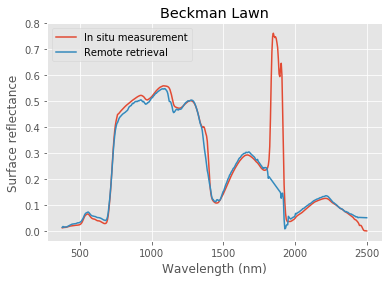

In [71]:
wl_insitu, rfl_insitu, fwhm = s.loadtxt('../data/beckmanlawn_reflectance.txt').T

wavelengths = fm.wl
rfl_insitu = spectrumResample(rfl_insitu, wl_insitu, fm.instrument.wl, fm.instrument.fwhm)
plt.plot(wavelengths,rfl_insitu)
plt.plot(wavelengths,rfl_est)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.title('Beckman Lawn')
plt.legend(['In situ measurement','Remote retrieval'])

Note that there is a term we have set to zero in our instrument model - the "cal_uncertainty_flatfield" which is uncorrelated uncertainty due to flat fielding errors.  

<b>Question:</b> Can we improve the match between the remote and in-situ reflectances by incorporating this source of uncertianty in our retrieval? What is its optimal value? How does it affect sensitivity to atmospheric parameters?